

![Compagnie aeriennes](http://cherchersonvoyage.fr/wp-content/uploads/2015/06/compagnies-mondiale.jpg)

#### Pascal Jauffret - Projet Python pour le Data Scientist

# Analyse de sentiments sur des compagnies aériennes à partir de tweets

Dans ce notebook Python on va utiliser un dataset qui contient des tweets d'avis utilisateurs sur des compagnies aériennes américaines. Un sentiment a été extrait de ces tweets (positif, neutre ou négatif), c'est la variable catégorielle que l'on va essayer de prédire.


On va procéder de façon méthodique en suivant plusieurs étapes :
* extraction des données à partir du CSV
* exploration des données sous forme de graphiques et de word cloud
* extraction des features (simple count)
* enrichissement des features grâce au "stemming"
* tests de différents classifieur (decision tree, random forest et modèle bayesiens naïfs)

## I - Exploration des données

On commence par récupérer le dataset au format CSV.

On utilise un LabelEncoder pour encoder les diffférents sentiments (string) en integer.

On peut voir les différentes colonnes du dataset. Nous ne nous interesserons qu'au contenu du tweet dans ce notebook.


In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sbn

from sklearn import preprocessing 

file = "Tweets.csv"

df = pd.read_csv(file, delimiter=",", encoding="UTF-8")

encoder = preprocessing.LabelEncoder()

df["encoded_sentiment"] = encoder.fit_transform(df["airline_sentiment"])
classes = encoder.classes_
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'encoded_sentiment'],
      dtype='object')

Le dataset contient 14640 tweets.

In [2]:
df.shape

(14640, 16)

On peut effectuer un premier groupby pour observer la répartition des sentiments par compagnies aeriennes.

In [3]:
groupby = df.groupby(["airline_sentiment","airline"], as_index=False).size()
groupby

airline_sentiment  airline       
negative           American          1960
                   Delta              955
                   Southwest         1186
                   US Airways        2263
                   United            2633
                   Virgin America     181
neutral            American           463
                   Delta              723
                   Southwest          664
                   US Airways         381
                   United             697
                   Virgin America     171
positive           American           336
                   Delta              544
                   Southwest          570
                   US Airways         269
                   United             492
                   Virgin America     152
dtype: int64

On utilise un stacked bar plot pour pouvoir visualiser cette répartition.

On peut voir qu'il y a toujours une majorité de sentiments négatifs et que la répartition entre positif, negatif et neutre est assez homogène entre les compagnies.Notre algorithme risque donc d'avoir tendance à prédire plus souvent un avis négatif.

On a aussi clairement  moins de tweets pour la compagnie Virgin America.



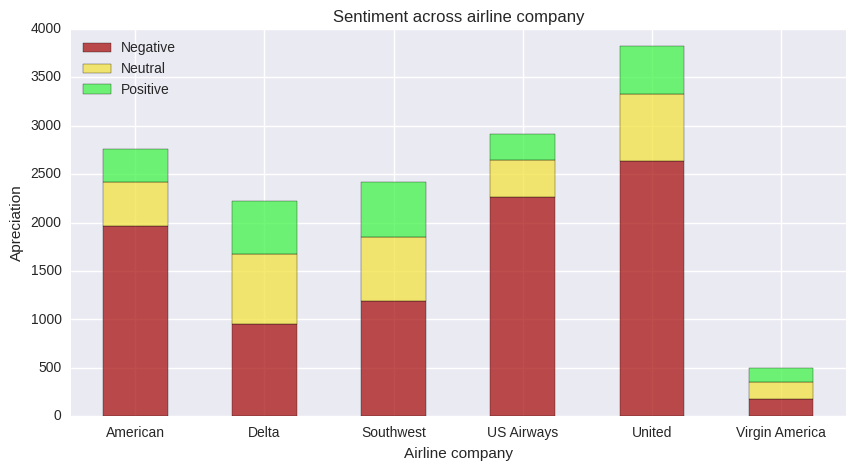

In [4]:
#From http://chrisalbon.com/python/matplotlib_stacked_bar_plot.html

import matplotlib.pyplot as plt

%matplotlib inline


# Create the general blog and the "subplots" i.e. the bars
f, ax1 = plt.subplots(1, figsize=(10,5))

# Set the bar width
bar_width = 0.5

# positions of the left bar-boundaries
bar_l = [i+1 for i in range(len(groupby['neutral']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the pre_score data
        groupby['negative'], 
        # set the width
        width=bar_width,
        # with the label pre score
        label='Negative', 
        # with alpha 0.5
        alpha=0.75, 
        # with color
        color='#a81212')

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the mid_score data
        groupby['neutral'], 
        # set the width
        width=bar_width,
        # with pre_score on the bottom
        bottom=groupby['negative'], 
        # with the label mid score
        label='Neutral', 
        # with alpha 0.5
        alpha=0.75, 
        # with color
        color='#f4e242')

# Create a bar plot, in position bar_1
ax1.bar(bar_l, 
        # using the post_score data
        groupby['positive'], 
        # set the width
        width=bar_width,
        # with pre_score and mid_score on the bottom
        bottom=[i+j for i,j in zip(groupby['negative'],groupby['neutral'])], 
        # with the label post score
        label='Positive', 
        # with alpha 0.5
        alpha=0.75, 
        # with color
        color='#42f44b')

# set the x ticks with names
plt.xticks(tick_pos, groupby["negative"].index)

# Set the label and legends
ax1.set_ylabel("Apreciation")
ax1.set_xlabel("Airline company")
plt.legend(loc='upper left')

# Set a buffer around the edge
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

plt.title("Sentiment across airline company")





On va maintenant regarder le contenu des tweets et voir quels sont les "tokens" les plus fréquents pour chacun des sentiments.

On utilise pour cela le TweetTokenizer du package nltk, il nous permet de découper les tweets en "tokens". L'intêret d'utiliser le TweetTokenizer et non pas un simple split sur les espaces est qu'il prend en compte les spécificités liées à Twitter. Par exemple, il va pouvoir garder le smiley :) (ne pas le séparer en : et ) ),  extraire les "@blablabla" des tweets, etc.

On utilise ensuite le CountVectorizer  de scikit qui permet de compter le nombre d'occurence de chacun des tokens pour chacune des lignes de notre dataset. On utilise les stopwords de nltk pour enlever les mots les plus fréquents comme "or" et "and". 

On choisit aussi de fixer le paramètre max_df qui permet lui de filtrer les tokens à partir d'un nombre d'occurence maximum. On le fixe à un % du nombre de lignes du dataset. On l'a ici fixé de façon empirique à 20% après de multiples essais (pour avoir des tokens qui nous paraissaient les plus explicatifs).

On choisit aussi de ne prendre que les 1000 features les plus fréquentes au sein du dataset.

On peut ainsi voir les tokens les plus fréquents pour chacun des sentiments.

In [5]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

tknzr = TweetTokenizer()
max_df_percentage = 0.2
max_df = int(df.shape[0]*max_df_percentage)

print("Taking max document frequency at {}".format(max_df))
count_vect = CountVectorizer(tokenizer= tknzr.tokenize, stop_words=stopwords.words('english'), max_df=max_df,max_features=1000)

counts = count_vect.fit_transform(df["text"])

reverse_index = {}

for key in count_vect.vocabulary_ :
    reverse_index[count_vect.vocabulary_[key]] = key

columns = []
for key in range(len(reverse_index)):
    columns.append(reverse_index[key])

word_df = pd.DataFrame(counts.todense(),columns=columns)

word_df["_airline_sentiment"] = df["airline_sentiment"]


neutral_tweet = word_df[word_df["_airline_sentiment"] == "neutral"].drop("_airline_sentiment",axis=1)
positive_tweet =  word_df[word_df["_airline_sentiment"] == "positive"].drop("_airline_sentiment",axis=1)
negative_tweet =  word_df[word_df["_airline_sentiment"] == "negative"].drop("_airline_sentiment",axis=1)


sum_neutral = neutral_tweet.T.sum(axis=1).sort_values(ascending=False)
sum_positive = positive_tweet.T.sum(axis=1).sort_values(ascending=False)
sum_negative = negative_tweet.T.sum(axis=1).sort_values(ascending=False)

print("Top 50 Neutral keywords :")
print(sum_neutral[0:50])
print("\n Top 50 Positive keywords :")
print(sum_positive[0:50])
print("\n Top 50 Negative keywords :")
print(sum_negative[0:50])


Taking max document frequency at 2928


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Top 50 Neutral keywords :
@jetblue          729
@southwestair     670
-                 244
get               238
:                 209
please            180
...               179
@virginamerica    175
flights           164
need              164
help              163
thanks            156
"                 134
)                 128
(                 125
would             122
dm                122
i'm               119
us                107
tomorrow          106
fleek             106
know              104
/                 104
“                 104
”                 103
fleet's           102
cancelled         101
&                  98
way                92
time               92
change             87
it's               80
one                78
new                77
like               77
flying             77
back               77
number             76
fly                75
today              75
'                  74
see                70
go                 70
thank              69
got   

Ces tokens les plus fréquents peuvent aussi être visualisés sous la forme d'un Word Cloud. Pour cela on doit en changer légèrement le format :

In [6]:
from wordcloud import WordCloud

frequencies_negative = [_ for _ in sum_negative[0:100].iteritems()]
frequencies_positive = [_ for _ in sum_positive[0:100].iteritems()]
frequencies_neutral = [_ for _ in sum_neutral[0:100].iteritems()]


print(frequencies_neutral)
print(frequencies_negative)
print(frequencies_positive)




[('@jetblue', 729), ('@southwestair', 670), ('-', 244), ('get', 238), (':', 209), ('please', 180), ('...', 179), ('@virginamerica', 175), ('flights', 164), ('need', 164), ('help', 163), ('thanks', 156), ('"', 134), (')', 128), ('(', 125), ('would', 122), ('dm', 122), ("i'm", 119), ('us', 107), ('tomorrow', 106), ('fleek', 106), ('know', 104), ('/', 104), ('“', 104), ('”', 103), ("fleet's", 102), ('cancelled', 101), ('&', 98), ('way', 92), ('time', 92), ('change', 87), ("it's", 80), ('one', 78), ('new', 77), ('like', 77), ('flying', 77), ('back', 77), ('number', 76), ('fly', 75), ('today', 75), ("'", 74), ('see', 70), ('go', 70), ('thank', 69), ('got', 68), ('check', 65), ('email', 64), ('follow', 63), ('airport', 63), ('ticket', 63), ('make', 62), ('hi', 60), ('could', 60), ('2', 57), ('travel', 56), ('rt', 56), ('first', 56), ("don't", 56), ('service', 55), ('sent', 55), ('going', 54), ('weather', 54), ('next', 53), ('still', 52), ('plane', 52), ('yes', 50), ('#destinationdragons', 50

On visualise ainsi le WordCloud des tokens associé au sentiment négatif.

On peut voir qu'ils ont du sens, "cancelled", "hold", "service" sont bien des tokens que l'on aurait associé à un sentiment négatif. Par contre, les tokens "@jetblue", "@southwestair" sont génériques et risquent d'être présent aussi dans les autres sentiments

Negative tagcloud


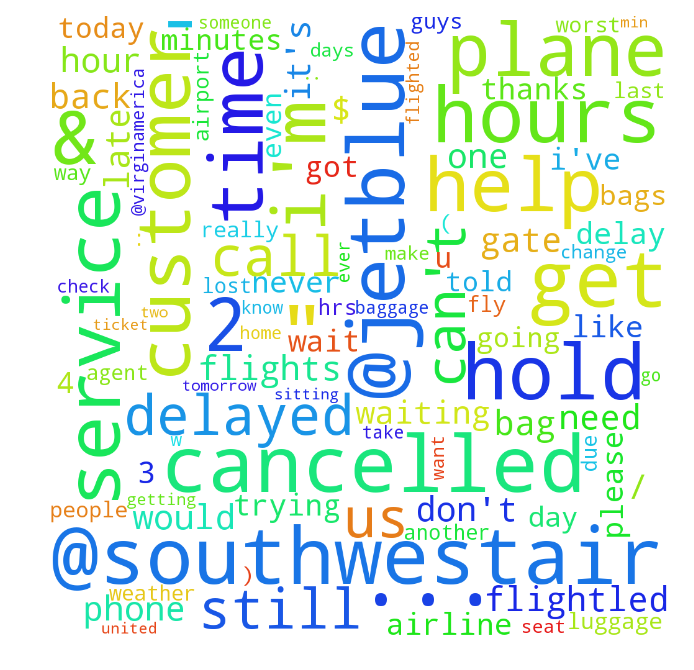

In [7]:
wordcloud = WordCloud(width=1000, height=1000,background_color="white").fit_words(frequencies=frequencies_negative)


print("Negative tagcloud")
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

On observe ici le Word Cloud des tokens associés au sentiment neutre. "please", "need", "would" en sont des exemples, on peut se dire que ces tweets correspondent à des questions que les clients ont posé à la compagnie.

On retrouve encore "@jetblue" et "@southwestair". C'est ici qu'on se rend compte de l'utilité du paramètre max_df. Si on avait baissé le pourcentage on aurait peut être plus eu les tokens comme "@jetblue" mais l'on aurait perdu des tokens expliquatifs comme "please". 

Neutral tagcloud


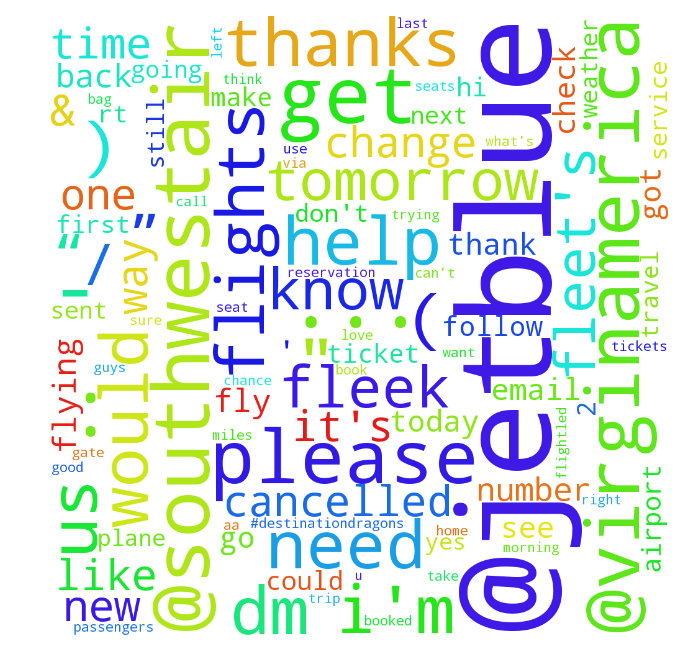

In [8]:
wordcloud = WordCloud(width=1000, height=1000,background_color="white").fit_words(frequencies=frequencies_neutral)

print("Neutral tagcloud")
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

On observe maintenant le Word Cloud du sentiment positif. On y retrouve le token "thank", "love", "best", et encore comme précedemment "@jetblue", "@southwestair".

Positive tag cloud


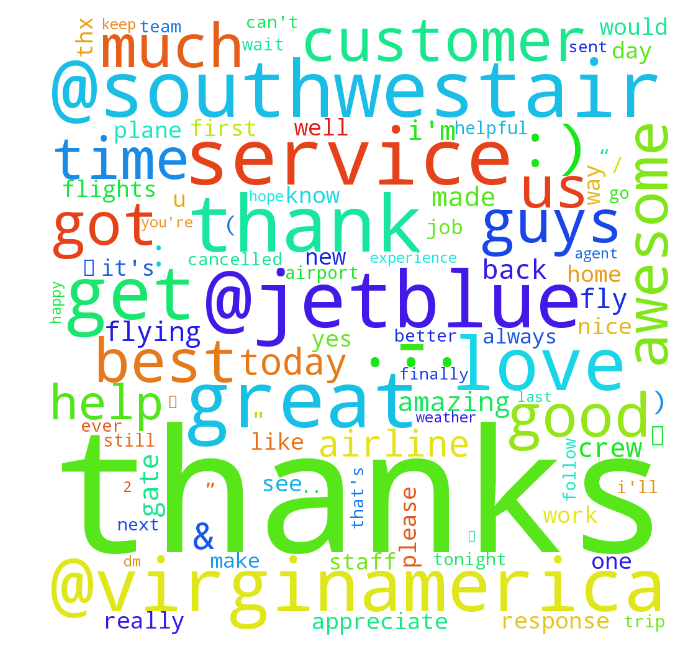

In [9]:
wordcloud = WordCloud(width=1000, height=1000,background_color="white").fit_words(frequencies=frequencies_positive)

print("Positive tag cloud")
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## II - Prédiction du sentiment utilisateur à partir du tweet

On va maintenant essayer de prédire le sentiment associé à un tweet.

On commence par séparer le dataset en ensemble d'entraînement et de test. On effectue ici une simple séparation en deux ensembles et pas de cross-validation. On utilise des proportions de 70% pour l'entraînement et 30% pour le test. 

On vérifie ensuite que l'on a bien la même distribution dans le test et le train en regardant la distribution du sentiment encodé avant split, puis dans l'ensemble d'entraînement et de test.

In [10]:
from sklearn.model_selection import train_test_split




X_train, X_test, y_train, y_test = train_test_split(df["text"], df["encoded_sentiment"], test_size=0.3)


print(df["encoded_sentiment"].describe())
print("\n")
print(y_train.describe())
print("\n")

print(y_test.describe())


count    14640.000000
mean         0.534495
std          0.756084
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: encoded_sentiment, dtype: float64


count    10248.000000
mean         0.536495
std          0.758309
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: encoded_sentiment, dtype: float64


count    4392.000000
mean        0.529827
std         0.750934
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: encoded_sentiment, dtype: float64


La fonction suivante nous permet de plotter les matrices de confusions.

In [11]:

#From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

On réeffectue les mêmes pré-traitements que lors de l'exploration, mais cette fois en utilisant seulement l'ensemble d'entraînement.

In [12]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

max_df_percentage = 0.2
max_df = int(X_train.shape[0]*max_df_percentage)
print("Taking max document frequency at {}".format(max_df))

tknzr = TweetTokenizer()
count_vect = CountVectorizer(tokenizer= tknzr.tokenize, stop_words=stopwords.words('english'), max_df=max_df,max_features=1000)


counts = count_vect.fit_transform(X_train)

reverse_index = {}

for key in count_vect.vocabulary_ :
    reverse_index[count_vect.vocabulary_[key]] = key

columns = []
for key in range(len(reverse_index)):
    columns.append(reverse_index[key])

word_df = pd.DataFrame(counts.todense(),columns=columns)




Taking max document frequency at 2049


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


On va commencer par voir ce que l'on obtient en utilisant un simple Decision Tree. On affiche ensuite la matrice de confusion et le score de précision obtenu sur l'ensemble de test.

On peut observer la logique de l'arbre de décision obtenu. Le mot "thank" est le plus discriminant, "hours" et "anyway" permettent aussi de faire la différence entre négatif et positif.

La matrice de confusion nous montre que l'on se trompe le plus souvent en prédisant un label négatif alors qu'il est positif ou neutre.

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Accuracy score on test set : 0.6778233151183971
Confusion matrix, without normalization
[[2643    8  105]
 [ 849   36   60]
 [ 388    5  298]]


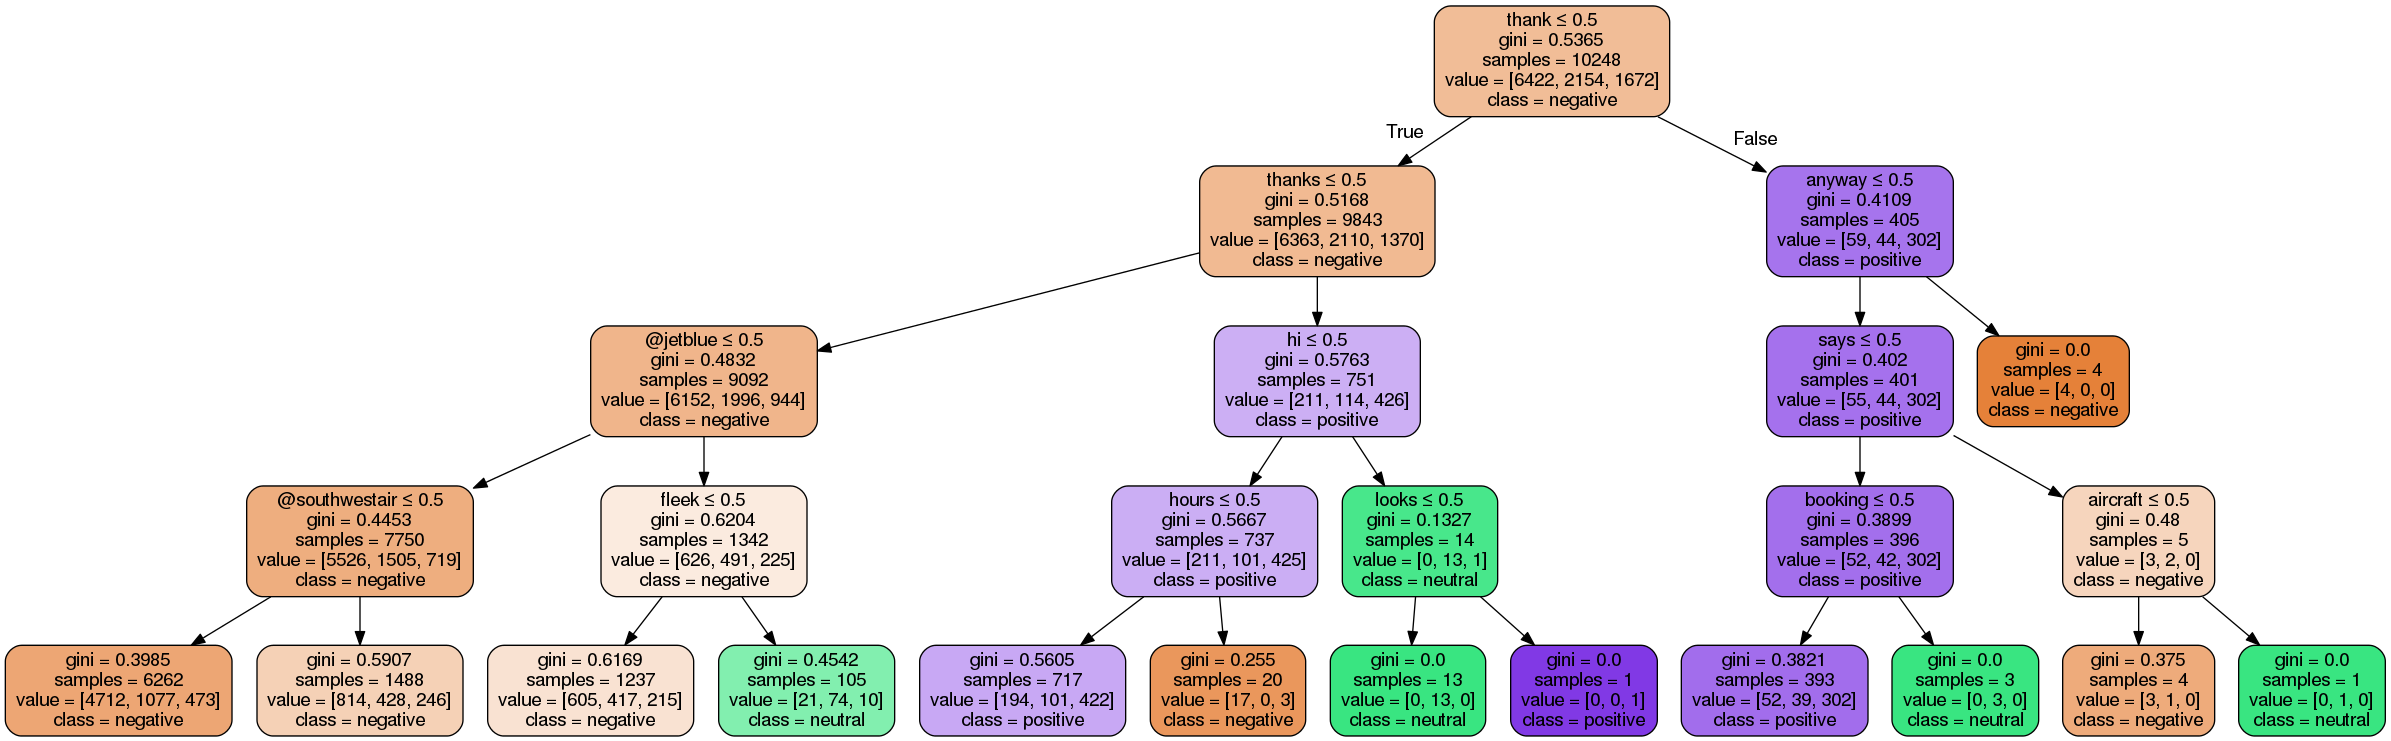

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


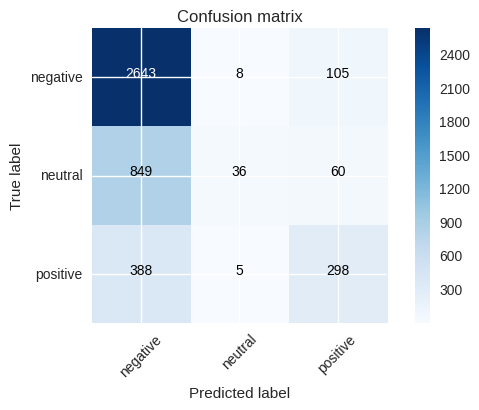

In [13]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

clf = DecisionTreeClassifier(max_depth=4)


clf.fit(counts,y_train)
counts_test = count_vect.transform(X_test)

score = clf.score(counts_test, y_test)

print("Accuracy score on test set : {}".format(score))

cm = confusion_matrix(y_test, clf.predict(counts_test))

plot_confusion_matrix(cm,classes, normalize=False)

from IPython.display import Image
import pydotplus
dot_data = export_graphviz(clf, out_file=None,class_names=classes,feature_names=columns,  filled=True, rounded=True, special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Après avoir utilisé un simple arbre de décision, on va cette fois utiliser une random forest, et voir quel score on obtient. L'implémentation des Random Forest sous scikit nous permet aussi d'observer l'importance de chacune des variables.

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Accuracy score on test set : 0.7600182149362478
Confusion matrix, without normalization
[[2537  136   83]
 [ 477  384   84]
 [ 177   97  417]]


,Importance
thanks,0.044373
thank,0.043830
@jetblue,0.018714
great,0.016865
@southwestair,0.013767
hold,0.009660
awesome,0.009648
cancelled,0.008987
delayed,0.008821
@virginamerica,0.008731


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


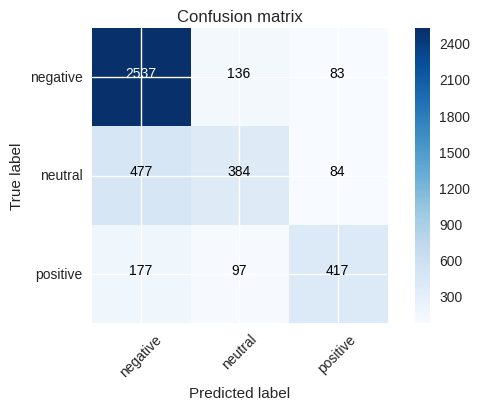

In [14]:

clf = RandomForestClassifier(max_depth=100,n_estimators=100)
clf.fit(counts,y_train)

counts_test = count_vect.transform(X_test)

score = clf.score(counts_test, y_test)

print("Accuracy score on test set : {}".format(score))

cm = confusion_matrix(y_test, clf.predict(counts_test))

plot_confusion_matrix(cm,classes, normalize=False)



df_importance = pd.DataFrame(clf.feature_importances_, index=columns)
df_importance =  df_importance.rename(columns={0 : "Importance"})
df_importance = df_importance.sort_values(by="Importance", ascending=False)
df_importance.head(20)

Le stemming est le fait de ne prendre que la racine des mots. 

Par exemple "cats" et "cat" une fois "stémmé" donneront "cat".

Cette technique permet de regrouper les mots ayant la même racine. On va maintenant voir si le stemming a un impact sur la précision de notre algorithme.

On peut aussi voir l'impact du stemming sur l'importance des variables qui sont maintenant "stemmé" avec par exemple "awesom", "thank", ou "great".

"thank" et "thanks" ont été regroupés en "thank".


Taking max document frequency at 2049


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Accuracy score on test set : 0.7695810564663024
Confusion matrix, without normalization
[[2549  139   68]
 [ 443  414   88]
 [ 179   95  417]]


,Importance
thank,0.079076
@jetblu,0.018296
great,0.014647
hour,0.012836
@southwestair,0.012759
delay,0.011534
cancel,0.009187
hold,0.008494
awesom,0.008326
@virginamerica,0.007942


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


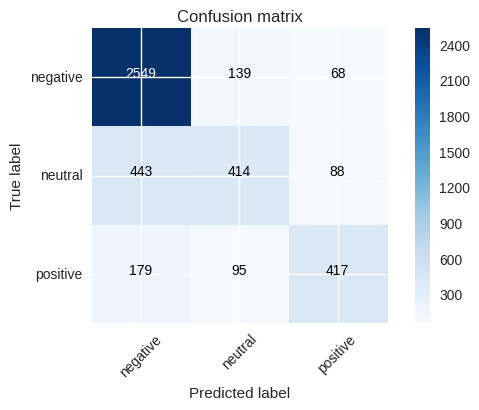

In [15]:
from nltk.stem.porter import PorterStemmer


max_df_percentage = 0.2
max_df = int(X_train.shape[0]*max_df_percentage)
print("Taking max document frequency at {}".format(max_df))
stemmer = PorterStemmer()
tknzr = TweetTokenizer()

def cust_tokenizer(sentence):
    toks = tknzr.tokenize(sentence)
    toks = [stemmer.stem(word=token) for token in toks]
    return toks

count_vect = CountVectorizer(tokenizer=cust_tokenizer, stop_words=stopwords.words('english'), max_df=max_df,max_features=1000)


counts = count_vect.fit_transform(X_train)

reverse_index = {}

for key in count_vect.vocabulary_ :
    reverse_index[count_vect.vocabulary_[key]] = key

columns = []
for key in range(len(reverse_index)):
    columns.append(reverse_index[key])

word_df = pd.DataFrame(counts.todense(),columns=columns)


clf = RandomForestClassifier(max_depth=100,n_estimators=100)
clf.fit(counts,y_train)

counts_test = count_vect.transform(X_test)

score = clf.score(counts_test, y_test)

print("Accuracy score on test set : {}".format(score))

cm = confusion_matrix(y_test, clf.predict(counts_test))

plot_confusion_matrix(cm,classes, normalize=False)



df_importance = pd.DataFrame(clf.feature_importances_, index=columns)
df_importance =  df_importance.rename(columns={0 : "Importance"})
df_importance = df_importance.sort_values(by="Importance", ascending=False)
df_importance.head(20)


On peut voir que l'on a gagné presque 1% de précision avec le stemming.

On va maintenant explorer d'autre classifieur pour voir lequel nous permet d'obtenir la meilleure précision.

Pour l'instant on a utilisé un arbre de décision peu profond, et une random forest de profondeur 100 à 100 estimateurs. 

On va tester :
- Une random forest avec de nombreux estimateurs peu profonds
- Une random forest avec moins d'estimateurs mais beaucoup de profondeur


In [16]:
def test_classifier(clf, classes, count_vect, counts, y_train):
    clf.fit(counts,y_train)

    counts_test = count_vect.transform(X_test)

    score = clf.score(counts_test, y_test)

    print("Accuracy score on test set : {}".format(score))

    cm = confusion_matrix(y_test, clf.predict(counts_test))

    plot_confusion_matrix(cm,classes, normalize=False)
    
    return score

La Random Forest avec peu de profondeur et beaucoup d'estimateurs donne une mauvaise précision. Les Random Forest fonctionnent en effet mieux avec des arbres très profonds, l'idée étant d "overfitter" sur les sous-ensemble obtenus après remise et de moyenner (ou utiliser un vote) les résultats pour faire baisser la variance. 

Les algorithmes type Gradient Boosting peuvent, eux, par contre fonctionner pour des arbres peu profonds mais très nombreux.

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Accuracy score on test set : 0.6438979963570127
Confusion matrix, without normalization
[[2747    8    1]
 [ 913   31    1]
 [ 637    4   50]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


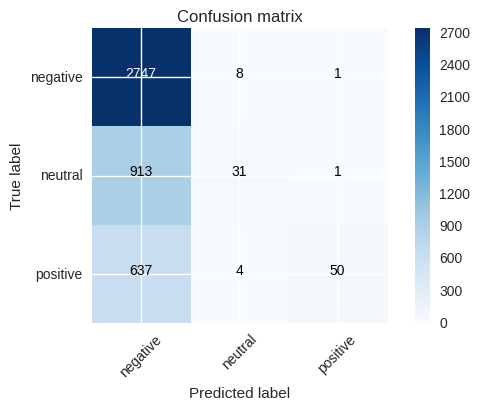

In [17]:
clf = RandomForestClassifier(max_depth=10,n_estimators=500)

score_short_multiple_rf = test_classifier(clf=clf, classes=classes, count_vect=count_vect, counts=counts, y_train=y_train)


On obtient une précision correcte avec des arbres profonds mais peu nombreux. On obtient néanmoins de meilleurs résultats avec moins de profondeur et plus d'estimateurs (il est probable que les arbres n'atteignent pas forcément leur profondeur maximum de 500 ou 1000).

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


Accuracy score on test set : 0.7545537340619308
Confusion matrix, without normalization
[[2447  227   82]
 [ 381  475   89]
 [ 191  108  392]]


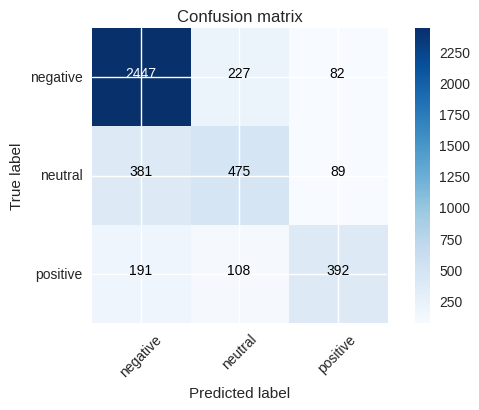

In [18]:
clf = RandomForestClassifier(max_depth=1000,n_estimators=10)

score_short_multiple_rf = test_classifier(clf=clf, classes=classes, count_vect=count_vect, counts=counts, y_train=y_train)


On va maintenant tester des classifieurs dits "naif bayesien" qui sont basé sur les probabilité conditionnels. L'idée est de supposer que chacune des variables est indépendantes des autres.

On suppose que la probabilité d'obtenir une certaines classe conditionnée par une variable suit une certaine loi. On estime les paramètres de cette loi par maximum de vraissemblance, puis l'on calcule la classe la plus probable pour l'ensemble des valeurs de chacune des variables (par une simple multiplication des likelihood).

Malheureusement, l'implémentation dans scikit de ces algorithmes ne supporte pas l'utilisation des matrices sparse, on est donc obligé de "densifier" les matrices, ce qui consomme du CPU.

In [19]:
def test_classifier_dense(clf, classes, count_vect, counts, y_train):
    clf.fit(counts.toarray(),y_train)

    counts_test = count_vect.transform(X_test).toarray()

    score = clf.score(counts_test, y_test)

    print("Accuracy score on test set : {}".format(score))

    cm = confusion_matrix(y_test, clf.predict(counts_test))

    plot_confusion_matrix(cm,classes, normalize=False)
    
    return score

Le modèle Gaussien donne de mauvais résultats. Il a tendance à prédire positif alors que le vrai sentiment est négatif ou neutre.

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Accuracy score on test set : 0.43101092896174864
Confusion matrix, without normalization
[[ 991  662 1103]
 [  34  298  613]
 [  28   59  604]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


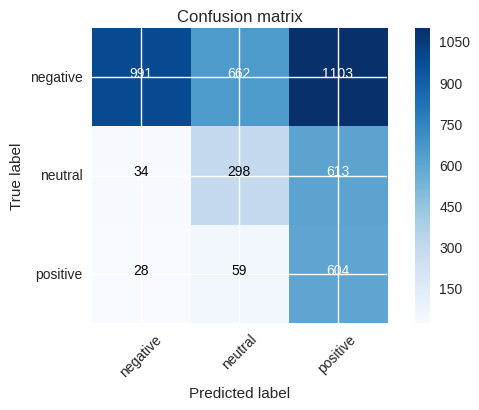

In [20]:



from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
score_gaussian_nb = test_classifier_dense(clf=clf, classes=classes, count_vect=count_vect, counts=counts, y_train=y_train)



Les modèles multinomiaux et "de Bernoulli" donnent de bien meilleurs résultats. 

On obtient la meilleure précision 77.5% avec le modèle de Bernoulli.

/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Accuracy score on test set : 0.7716302367941712
Confusion matrix, without normalization
[[2435  216  105]
 [ 354  484  107]
 [ 140   81  470]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


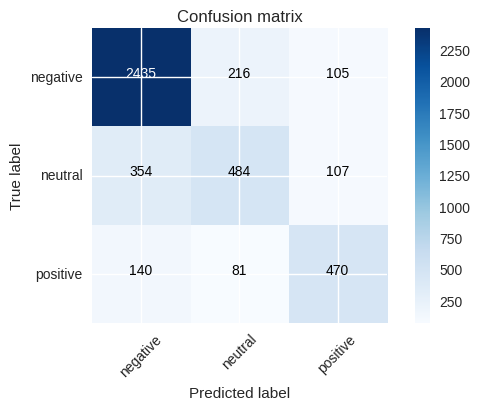

In [21]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
score_multinomial_nb = test_classifier_dense(clf=clf, classes=classes, count_vect=count_vect, counts=counts, y_train=y_train)




/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Accuracy score on test set : 0.7786885245901639
Confusion matrix, without normalization
[[2340  305  111]
 [ 233  601  111]
 [ 109  103  479]]


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


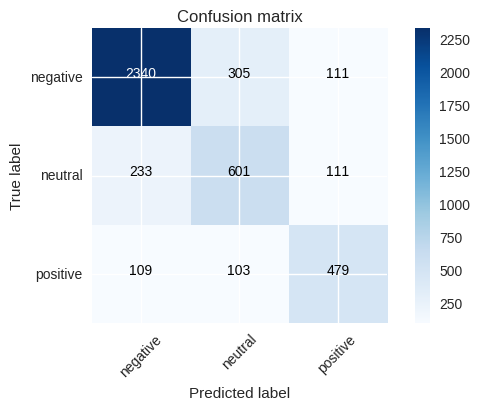

In [22]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
score_bernoulli_nb = test_classifier_dense(clf=clf, classes=classes, count_vect=count_vect, counts=counts, y_train=y_train)




## III - Conclusion



Ce notebook est une première approche d'un problème complexe qui peut être résolu de nombreuse façons différentes.

Le meilleur modèle obtenu est le modèle naïf bayesien "de Bernoulli" avec une précision de 77.5%. Malheureusement, il n'est pas interessant de le déployer en production car il ne supporte pas les matrices dites "sparse". Il serait plus judicieux de déployer une Random Forest bien plus scalable. Une précision de 76% semble être exploitable, mais l'on porurait essayer d'améliorer ce score.

Ce modèle (les random forest) peut avoir une durée de vie relativement élevée. La langue n'évolue pas très rapidement, donc il n'aurait pas forcément besoin d'être ré-entraîné souvent. "Worse" sera toujours lié à un sentiment négatif dans la langue anglaise. Pour détecter d'éventuelles baisses de performances, il faudrait régulièrement fournir un ensemble de nouveaux tweets évalués par des experts et monitorer la performance du modèle. L'estimation d'un nouveau modèle ne peut pas forcément être faite à partir du modèle précédent, il faut ré-entraîner sur toutes les nouvelles données.
 
Le modèle pourrait facilement passer à l'échelle, le facteur limitant étant juste le nombre de feature que l'on selectionne lors de son entraînement. Il pourrait être interessant de voir l'évolution de la performance en fonction du nombre de features.


Le modèle a, en général, tendance à sous-estimer (surestimer le négatif, beaucoup de faux négatif) le sentiment d'un tweet vu que l'on a beaucoup plus de sentiments négatifs dans l'ensemble d'entraînement. Il faut prendre en compte cette information dans l'application que l'on produira ou bien essayer d'optimiser le modèle pour avoir de meilleurs résultats.

On pourrait utiliser ce modèle en production pour être capable de prédire l'opinion publique sur une nouvelle compagnie aérienne et pouvoir évaluer l'impact des stratégies d'entreprise. L'idée pourrait être de vendre un abonnement aux entreprises pour l'accès aux opinions sur leurs compagnie et éventuellement les concurrents.

On pourrait généraliser notre approche et construire une entreprise d'analyse de sentiment sur des domaines variés. On entraînerait un immense modèle qui serait capable d'évaluer un sentiment indépendemment d'un contexte (ici les compagnies aériennes). On pourrait ensuite utiliser nos sentiments pour prédire les cours de la bourse, ou autre, et les revendre.

## IV - Pour aller plus loin

On peut explorer encore de nombreuses pistes pour améliorer le modèle :
* Rajouter une couche de TF-IDF, on aurait plus simplement le compte du nombre de tokens mais un score lié à la rareté du mot dans le corpus et sa fréquence au sein du document.
* Tester des modèles à base de Gradient Boosting, et pourquoi pas la librairie XGBoost connue pour son efficacité (et sa scalabilité)
* Tester la lemmatisation, qui est une technique plus avancée (et donc plus couteuse ?) que le stemming qui permet par exemple de regrouper "good" et "better"
* Tester l'utilisation non pas de tokens mais de N-gram (groupes de N mots ou bien N lettres)
* Réfléchir à l'utilisation d'autres features (comme la date du tweet ou la localisation du tweet)